Total positive reviews: 28566
Total negative reviews: 4192


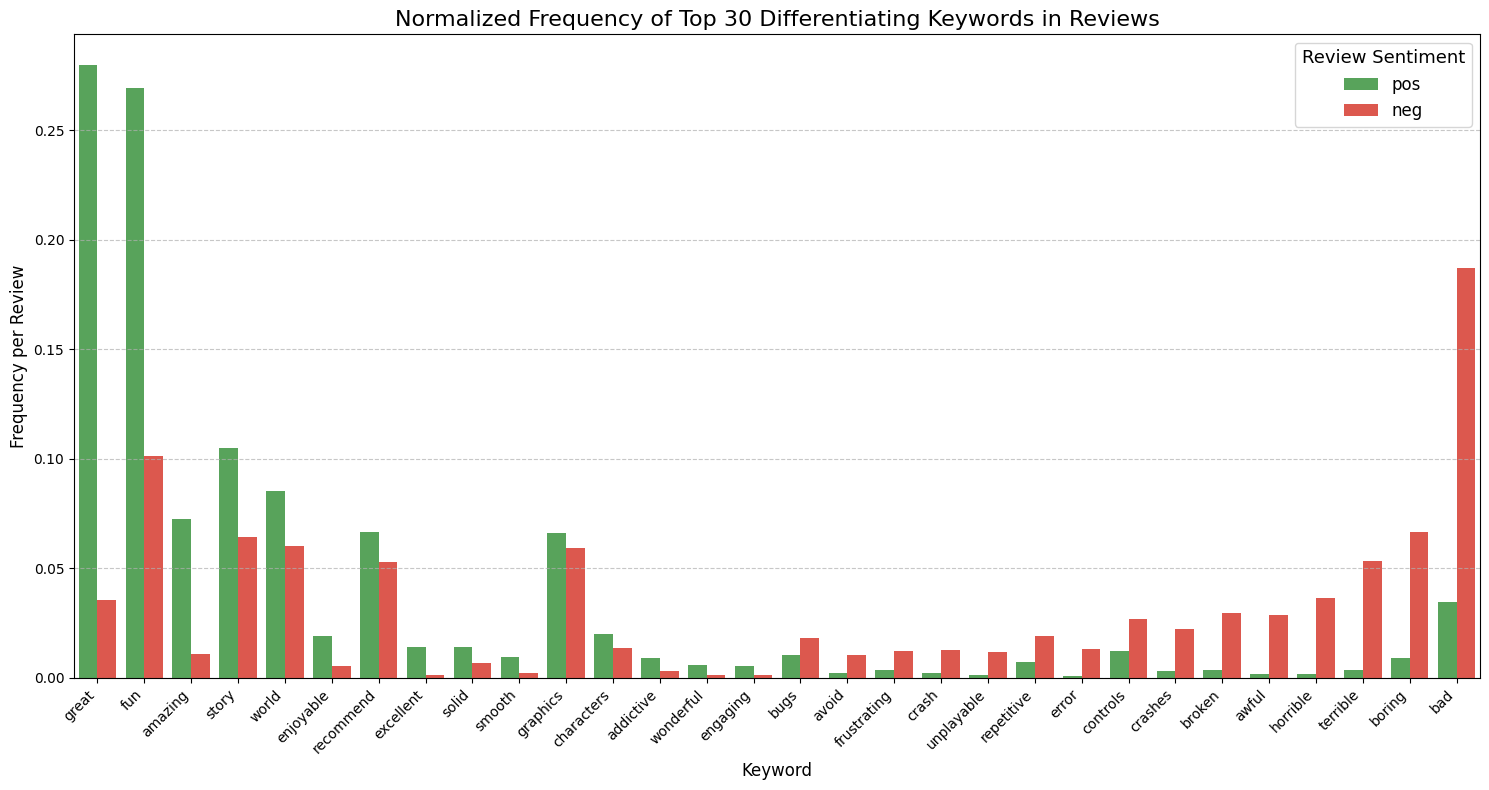


Top words more frequent in positive reviews:
          word  freq_pos  freq_neg  frequency_difference
37       great  0.279738  0.035782              0.243956
33         fun  0.269411  0.101384              0.168028
1      amazing  0.072359  0.010735              0.061624
62       story  0.105160  0.064170              0.040990
74       world  0.085276  0.060353              0.024923
24   enjoyable  0.019359  0.005487              0.013872
56   recommend  0.066408  0.052719              0.013688
27   excellent  0.014213  0.001193              0.013020
59       solid  0.014318  0.006918              0.007400
58      smooth  0.009417  0.002385              0.007031
36    graphics  0.066163  0.059399              0.006764
12  characters  0.020199  0.013836              0.006363
0    addictive  0.008927  0.003101              0.005826
73   wonderful  0.005951  0.001193              0.004758
23    engaging  0.005601  0.001193              0.004408

Top words more frequent in negative revie

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Load Hadoop results ---
df_hadoop = pd.read_csv("output_h1.txt", sep="\t", header=None, names=["key", "count"])
df_hadoop[["label", "word"]] = df_hadoop["key"].str.split("_", expand=True)

# --- 2. Load original dataset for normalization ---
df_reviews = pd.read_csv("clean_sample.csv")
n_pos = (df_reviews["sentiment_combined"] == "positive").sum()
n_neg = (df_reviews["sentiment_combined"] == "negative").sum()
total_reviews = {"pos": n_pos, "neg": n_neg}

print(f"Total positive reviews: {n_pos}")
print(f"Total negative reviews: {n_neg}")

# --- 3. Normalize word frequency ---
df_hadoop["normalized_frequency"] = df_hadoop.apply(
    lambda row: (
        row["count"] / total_reviews[row["label"]]
        if total_reviews.get(row["label"], 0) > 0
        else 0
    ),
    axis=1,
)

# --- 4. Pivot: check if both pos and neg exist ---
pivot_df = df_hadoop.pivot_table(
    index="word", columns="label", values="normalized_frequency", fill_value=0
).reset_index()
pivot_df.columns.name = None

# Check columns and rename if both exist
if "pos" in pivot_df.columns and "neg" in pivot_df.columns:
    pivot_df = pivot_df.rename(columns={"pos": "freq_pos", "neg": "freq_neg"})
elif "pos" in pivot_df.columns:
    pivot_df = pivot_df.rename(columns={"pos": "freq_pos"})
    pivot_df["freq_neg"] = 0  # add empty negative column
elif "neg" in pivot_df.columns:
    pivot_df = pivot_df.rename(columns={"neg": "freq_neg"})
    pivot_df["freq_pos"] = 0  # add empty positive column
else:
    raise ValueError("❌ Neither 'pos' nor 'neg' columns found in pivoted data.")

# --- 5. Calculate frequency difference and select top keywords ---
pivot_df["frequency_difference"] = pivot_df["freq_pos"] - pivot_df["freq_neg"]
N_TOP_WORDS = 15
sorted_words_by_diff = pivot_df.sort_values(by="frequency_difference", ascending=False)
top_pos_words = sorted_words_by_diff.head(N_TOP_WORDS)
top_neg_words = sorted_words_by_diff.tail(N_TOP_WORDS).sort_values(
    by="frequency_difference", ascending=False
)
words_to_plot = pd.concat([top_pos_words, top_neg_words])["word"].unique()

# --- 6. Filter and prepare for plotting ---
plot_df = df_hadoop[df_hadoop["word"].isin(words_to_plot)].copy()
ordered_words = sorted_words_by_diff[sorted_words_by_diff["word"].isin(words_to_plot)][
    "word"
].tolist()
plot_df["word"] = pd.Categorical(
    plot_df["word"], categories=ordered_words, ordered=True
)
plot_df["label"] = pd.Categorical(
    plot_df["label"], categories=["pos", "neg"], ordered=True
)

# --- 7. Plot ---
plt.figure(figsize=(15, 8))
sns.barplot(
    data=plot_df.sort_values(by=["word", "label"]),
    x="word",
    y="normalized_frequency",
    hue="label",
    palette={"pos": "#4CAF50", "neg": "#F44336"},
)
plt.title(
    f"Normalized Frequency of Top {N_TOP_WORDS*2} Differentiating Keywords in Reviews",
    fontsize=16,
)
plt.ylabel("Frequency per Review", fontsize=12)
plt.xlabel("Keyword", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Review Sentiment", title_fontsize="13", fontsize="12")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# --- 8. Optional: Print top keywords ---
print("\nTop words more frequent in positive reviews:")
print(top_pos_words[["word", "freq_pos", "freq_neg", "frequency_difference"]])

print("\nTop words more frequent in negative reviews:")
print(top_neg_words[["word", "freq_pos", "freq_neg", "frequency_difference"]])